In [1]:
import pandas as pd
import glob
import os

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# add reference alleles
reference = pd.read_csv('reference_genome.csv')

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# Display the combined DataFrame
df_combined.head()

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,OR.fixed,SE.fixed,p.fixed,beta.random,OR.random,SE.random,p.random,description,group,reference_hg38
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,0.999849,0.005953,0.979734,0.006178,1.006197,0.012305,0.615617,Dermatophytosis / Dermatomycosis,infectious diseases,C
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,0.999688,0.006069,0.959032,0.010304,1.010357,0.015522,0.506800,Dermatophytosis,infectious diseases,C
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,1.002185,0.006721,0.745428,0.009433,1.009478,0.016507,0.567693,Dermatophytosis of nail,infectious diseases,C
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,1.000275,0.010969,0.980001,0.018498,1.018670,0.022352,0.407917,Althete's foot,infectious diseases,C
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,1.027980,0.016599,0.096426,0.027595,1.027980,0.016599,0.096426,Dermatophytosis of the body,infectious diseases,C


In [2]:
# clean phenotype data
clean_phenotypes = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace(r"[',\]\[\(\)/;&\.]", "", regex = True)


# extract the SNP data
df_combined[['chrom', 'pos', 'alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# rename necessary cols
df_combined = df_combined.assign(

    # clean
    clean_phenotype = clean_phenotypes,
    phenostring = df_combined.description,

    # rename
    reference = df_combined.reference_hg38,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,
    category = df_combined.group,

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR

In [3]:
df_combined.columns

Index(['phenotype', 'snp', 'adjustment', 'beta', 'OR', 'SE', 'p', 'type',
       'n_total', 'n_cases', 'n_controls', 'HWE_p.min', 'allele_freq',
       'n_no_snp', 'k_studies', 'tau2', 'I2.percent', 'Q', 'Q.df', 'Q.p',
       'beta.fixed', 'OR.fixed', 'SE.fixed', 'p.fixed', 'beta.random',
       'OR.random', 'SE.random', 'p.random', 'description', 'group',
       'reference_hg38', 'chrom', 'pos', 'alternate', 'clean_phenotype',
       'phenostring', 'reference', 'num_samples', 'num_controls', 'num_cases',
       'se', 'category', 'or'],
      dtype='object')

In [4]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'beta', 'se', 'or',  'num_samples', 'num_controls', 'num_cases', 'category'
]

In [5]:
# drop all snps that where reference == alternate
df_combined = df_combined[df_combined.reference != df_combined.alternate] 

In [6]:
# check that we got all chromosomes
df_combined[df_combined.chrom.isna()][['snp'] + final_cols]

,snp,chrom,pos,reference,alternate,p,beta,se,or,num_samples,num_controls,num_cases,category


In [7]:
# sort
df_combined = df_combined.sort_values(['clean_phenotype', 'chrom', 'pos'])

In [8]:
# final file
df_combined[['phenostring', 'clean_phenotype'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

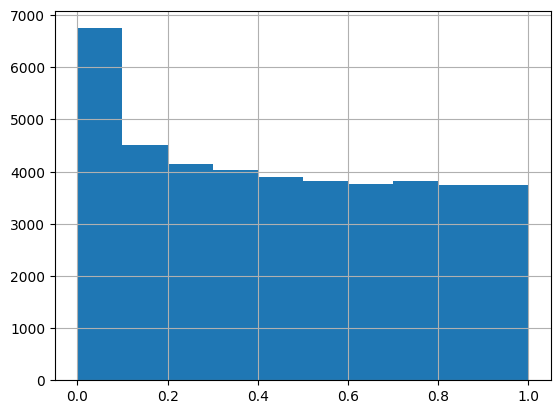

In [9]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

I need to format the files a la Github specifications. One file per phenotype

In [10]:
# filtering out phenotypes with n = 0
# this isn't a problem with the phenotypes, this is because we filtered out some genes because the reference alleles didn't match
n_totals = df_combined.groupby('clean_phenotype').n_total.sum()
phenotypes_n_0 = pd.Series(n_totals[n_totals == 0].index)
df_combined = df_combined[~ df_combined.phenotype.isin(phenotypes_n_0)]

In [11]:
unique_phenotypes = df_combined[['clean_phenotype', 'phenostring', 'category']].drop_duplicates()
clean_phenotypes = unique_phenotypes.clean_phenotype

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != clean_phenotypes.nunique():
    raise ValueError("Non unique phenotype categories. One or more phenotypes have multiple categories")

In [12]:
# remove all files in folder
import os
import glob

files = glob.glob('clean_data/*')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in clean_phenotypes:
    df_combined[df_combined.clean_phenotype == pheno][final_cols].to_csv('clean_data/' + pheno + '.csv', index = False)

In [14]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv',
    phenocode = unique_phenotypes.clean_phenotype)[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [15]:
pheno_df

,assoc_files,category,phenocode,phenostring
29017,clean_data/abdominal_aortic_aneurysm.csv,circulatory system,abdominal_aortic_aneurysm,Abdominal aortic aneurysm
29271,clean_data/abdominal_hernia.csv,digestive,abdominal_hernia,Abdominal hernia
29926,clean_data/abdominal_pain.csv,symptoms,abdominal_pain,Abdominal pain
29936,clean_data/abnormal_arterial_blood_gases.csv,symptoms,abnormal_arterial_blood_gases,Abnormal arterial blood gases
29155,clean_data/abnormal_chest_sounds.csv,respiratory,abnormal_chest_sounds,Abnormal chest sounds
...,...,...,...,...
29627,clean_data/vitiligo.csv,dermatologic,vitiligo,Vitiligo
29093,clean_data/voice_disturbance.csv,respiratory,voice_disturbance,Voice disturbance
28515,clean_data/von_willebrands_disease.csv,hematopoietic,von_willebrands_disease,Von willebrand's disease
29039,clean_data/wegeners_granulomatosis.csv,circulatory system,wegeners_granulomatosis,Wegener's granulomatosis


In [16]:
pheno_df[pheno_df.phenocode.str.match("'")]

,assoc_files,category,phenocode,phenostring


In [17]:
pheno_df.phenocode.value_counts()

phenocode
wheezing                                            1
abdominal_aortic_aneurysm                           1
abdominal_hernia                                    1
abdominal_pain                                      1
abnormal_arterial_blood_gases                       1
                                                   ..
abnormal_involuntary_movements                      1
abnormal_heart_sounds                               1
abnormal_granulation_tissue                         1
abnormal_glucose                                    1
abnormal_function_study_of_cardiovascular_system    1
Name: count, Length: 1771, dtype: int64

In [18]:
for i in pheno_df.phenocode:
    print(i)

abdominal_aortic_aneurysm
abdominal_hernia
abdominal_pain
abnormal_arterial_blood_gases
abnormal_chest_sounds
abnormal_coagulation_profile
abnormal_electrocardiogram_ecg_ekg
abnormal_findings_examination_of_lungs
abnormal_findings_on_examination_of_urine
abnormal_findings_on_mammogram_or_breast_exam
abnormal_findings_on_study_of_brain_andor_nervous_system
abnormal_function_study_of_cardiovascular_system
abnormal_glucose
abnormal_granulation_tissue
abnormal_heart_sounds
abnormal_involuntary_movements
abnormal_mammogram
abnormal_movement
abnormal_papanicolaou_smear_of_cervix_and_cervical_hpv
abnormal_posture
abnormal_reflex
abnormal_results_of_function_study_of_kidney
abnormal_results_of_function_study_of_liver
abnormal_results_of_function_study_of_pulmonary_system
abnormal_results_of_function_study_of_thyroid
abnormal_results_of_other_function_studies_bladder_pancreas_placenta_spleen_etc
abnormal_serum_enzyme_levels
abnormal_spermatozoa
abnormal_sputum
abnormal_tumor_markers
abnormal_we